# Цель работы

Исследование влияния различных методов уменьшения размерности (PCA, Isomap, t-SNE, UMAP) на качество кластеризации, оцененное с помощью внутренних метрик (Silhouette Score, Calinski–Harabasz Index, Davies–Bouldin Index) и внешних метрик (при наличии разметки)



# Теоретическая часть
## Методы уменьшения размерности (Dimensionality Reduction - DR)
+ PCA (Principal Component Analysis):

   + Линейный метод, максимизирующий дисперсию данных

   + Сохраняет глобальную структуру данных

   + Вычислительно эффективен

+ Isomap (Isometric Mapping):

   + Нелинейный метод, сохраняющий геодезические расстояния

   + Основан на многомерном шкалировании (MDS)

   + Эффективен для данных с нелинейной структурой

+ t-SNE (t-distributed Stochastic Neighbor Embedding):

   + Вероятностный метод, сохраняющий локальную структуру

   + Эффективен для визуализации

   + Вычислительно сложен для больших данных

+ UMAP (Uniform Manifold Approximation and Projection):

   + Основан на теории топологических пространств

   + Сохражает как локальную, так и глобальную структуру

   + Вычислительно эффективнее t-SNE

## Метрики кластеризации
+ Внутренние метрики:
   + Silhouette Score: Мера компактности и разделимости кластеров

   + Calinski–Harabasz Index: Отношение дисперсии между кластерами к дисперсии внутри кластеров

   + Davies–Bouldin Index: Среднее сходство между кластерами

+ Внешние метрики:
   + Adjusted Rand Index (ARI)

   + Adjusted Mutual Information (AMI)

   + Homogeneity, Completeness, V-measure

# Задание 1: Подготовка данных и реализация DR-методов

In [1]:
%pip install numpy pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install umap

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement umap (from versions: none)

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for umap


In [14]:
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch

Набор данных: Digits (1797 samples, 64 features, 10 classes)
Размерность: (1797, 64)
Количество классов: 10
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 40, Объясненная дисперсия: 0.951
Isomap выполнено за 2.06 сек
t-SNE выполнено за 2.40 сек
UMAP выполнено за 9.19 сек

Визуализация результатов DR-методов:


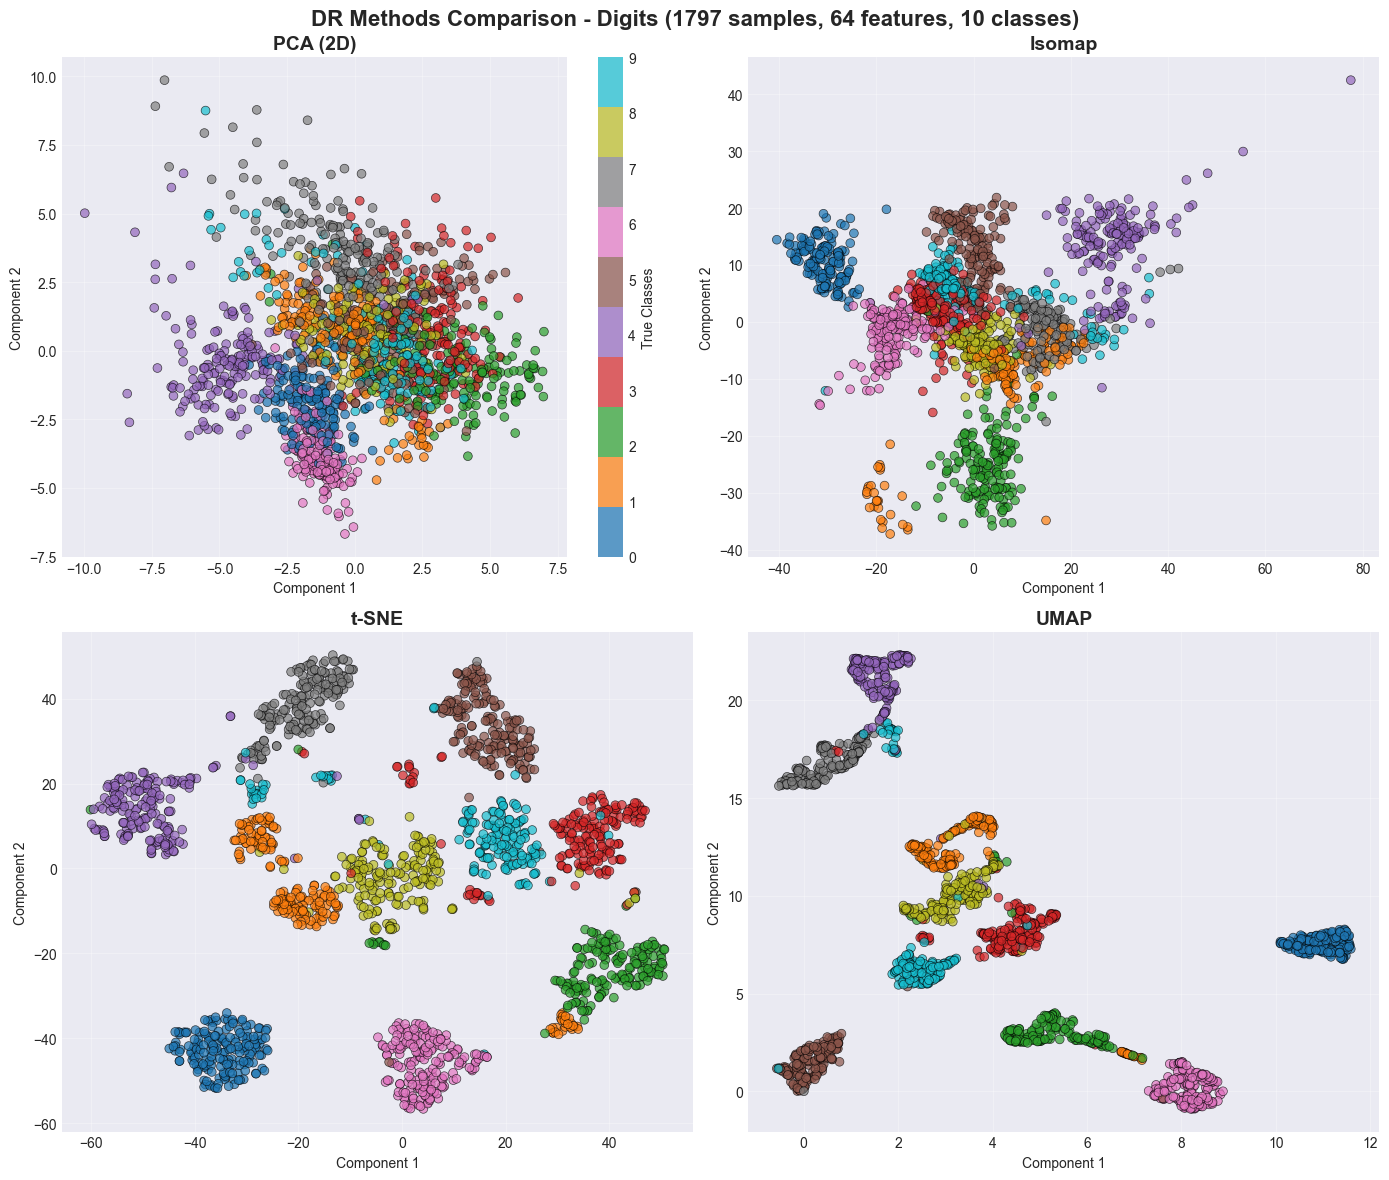

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap.umap_ as umap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score, adjusted_rand_score,
                             adjusted_mutual_info_score, homogeneity_completeness_v_measure)
import warnings
warnings.filterwarnings('ignore')
import time

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

class DRComparer:
    """Класс для сравнения различных методов уменьшения размерности"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.dr_methods = {}
        self.dr_results = {}
        
    def apply_pca(self, X, n_components=None, variance_threshold=0.95):
        """Применение PCA"""
        if n_components is None:
            pca = PCA(n_components=variance_threshold, random_state=self.random_state)
        else:
            pca = PCA(n_components=n_components, random_state=self.random_state)
        
        X_pca = pca.fit_transform(X)
        explained_variance = pca.explained_variance_ratio_
        
        self.dr_results['PCA'] = {
            'transformed': X_pca,
            'explained_variance': explained_variance,
            'n_components': X_pca.shape[1],
            'total_variance': explained_variance.sum()
        }
        
        return X_pca, pca
    
    def apply_isomap(self, X, n_components=2, n_neighbors=5):
        """Применение Isomap"""
        isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
        X_isomap = isomap.fit_transform(X)
        
        self.dr_results['Isomap'] = {
            'transformed': X_isomap,
            'n_components': n_components,
            'n_neighbors': n_neighbors
        }
        
        return X_isomap, isomap
    
    def apply_tsne(self, X, n_components=2, perplexity=30, learning_rate=200):
        """Применение t-SNE"""
        tsne = TSNE(n_components=n_components, 
                   perplexity=perplexity,
                   learning_rate=learning_rate,
                   random_state=self.random_state,
                   n_jobs=-1)
        
        X_tsne = tsne.fit_transform(X)
        
        self.dr_results['t-SNE'] = {
            'transformed': X_tsne,
            'n_components': n_components,
            'perplexity': perplexity
        }
        
        return X_tsne, tsne
    
    def apply_umap(self, X, n_components=2, n_neighbors=15, min_dist=0.1):
        """Применение UMAP"""
        reducer = umap.UMAP(n_components=n_components,
                          n_neighbors=n_neighbors,
                          min_dist=min_dist,
                          random_state=self.random_state,
                          n_jobs=-1)
        
        X_umap = reducer.fit_transform(X)
        
        self.dr_results['UMAP'] = {
            'transformed': X_umap,
            'n_components': n_components,
            'n_neighbors': n_neighbors,
            'min_dist': min_dist
        }
        
        return X_umap, reducer
    
    def apply_all_methods(self, X, n_components_2d=2):
        """Применение всех методов DR"""
        print("Применение методов уменьшения размерности...")
        print("-" * 50)
        
        results = {}
        
        # PCA (сохраняем 95% дисперсии)
        start = time.time()
        X_pca, pca_model = self.apply_pca(X, variance_threshold=0.95)
        pca_time = time.time() - start
        print(f"PCA выполнено за {pca_time:.2f} сек")
        print(f"  Компонент: {X_pca.shape[1]}, Объясненная дисперсия: {self.dr_results['PCA']['total_variance']:.3f}")
        
        # PCA для 2D визуализации
        pca_2d = PCA(n_components=n_components_2d, random_state=self.random_state)
        X_pca_2d = pca_2d.fit_transform(X)
        results['PCA_2D'] = X_pca_2d
        
        # Isomap
        start = time.time()
        X_isomap, isomap_model = self.apply_isomap(X, n_components=n_components_2d)
        isomap_time = time.time() - start
        print(f"Isomap выполнено за {isomap_time:.2f} сек")
        
        # t-SNE
        start = time.time()
        X_tsne, tsne_model = self.apply_tsne(X, n_components=n_components_2d)
        tsne_time = time.time() - start
        print(f"t-SNE выполнено за {tsne_time:.2f} сек")
        
        # UMAP
        start = time.time()
        X_umap, umap_model = self.apply_umap(X, n_components=n_components_2d)
        umap_time = time.time() - start
        print(f"UMAP выполнено за {umap_time:.2f} сек")
        
        # Сохраняем результаты
        results['PCA'] = X_pca
        results['PCA_2D'] = X_pca_2d
        results['Isomap'] = X_isomap
        results['t-SNE'] = X_tsne
        results['UMAP'] = X_umap
        
        # Информация о времени выполнения
        self.execution_times = {
            'PCA': pca_time,
            'Isomap': isomap_time,
            't-SNE': tsne_time,
            'UMAP': umap_time
        }
        
        return results

# Загрузка и подготовка данных
def load_dataset(dataset_name='digits'):
    """Загрузка набора данных"""
    if dataset_name == 'digits':
        data = datasets.load_digits()
        X = data.data
        y = data.target
        dataset_info = "Digits (1797 samples, 64 features, 10 classes)"
    elif dataset_name == 'wine':
        data = datasets.load_wine()
        X = data.data
        y = data.target
        dataset_info = "Wine (178 samples, 13 features, 3 classes)"
    elif dataset_name == 'iris':
        data = datasets.load_iris()
        X = data.data
        y = data.target
        dataset_info = "Iris (150 samples, 4 features, 3 classes)"
    else:
        raise ValueError(f"Неизвестный набор данных: {dataset_name}")
    
    # Стандартизация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"Набор данных: {dataset_info}")
    print(f"Размерность: {X.shape}")
    print(f"Количество классов: {len(np.unique(y))}")
    
    return X_scaled, y, data, dataset_info

# Загрузка данных
X, y_true, data, dataset_info = load_dataset('digits')

# Применение методов DR
dr_comparer = DRComparer(random_state=42)
dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)

# Визуализация DR-результатов
def visualize_dr_results(dr_results, y_true, dataset_info):
    """Визуализация результатов различных методов DR"""
    
    methods = ['PCA_2D', 'Isomap', 't-SNE', 'UMAP']
    titles = ['PCA (2D)', 'Isomap', 't-SNE', 'UMAP']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for idx, (method, title) in enumerate(zip(methods, titles)):
        X_dr = dr_results[method]
        
        scatter = axes[idx].scatter(X_dr[:, 0], X_dr[:, 1], 
                                   c=y_true, cmap='tab10', 
                                   s=40, alpha=0.7, edgecolor='k', linewidth=0.5)
        
        axes[idx].set_title(f'{title}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Component 1')
        axes[idx].set_ylabel('Component 2')
        axes[idx].grid(True, alpha=0.3)
        
        # Добавляем цветовую шкалу для первого графика
        if idx == 0:
            plt.colorbar(scatter, ax=axes[idx], label='True Classes')
    
    plt.suptitle(f'DR Methods Comparison - {dataset_info}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Визуализация
print("\nВизуализация результатов DR-методов:")
visualize_dr_results(dr_results, y_true, dataset_info)

# Задание 2: Реализация системы оценки кластеризации

In [58]:
class ClusteringEvaluator:
    """Комплексная система оценки качества кластеризации"""
    
    def __init__(self):
        self.results = {}
        
    def compute_all_metrics(self, X, labels, y_true=None, algorithm_name="", dr_method=""):
        """Вычисление всех метрик для кластеризации"""
        
        if len(np.unique(labels)) < 2:
            return {
                'n_clusters': len(np.unique(labels)),
                'internal_metrics': None,
                'external_metrics': None
            }
        
        # Внутренние метрики
        internal_metrics = {
            'silhouette': silhouette_score(X, labels),
            'calinski_harabasz': calinski_harabasz_score(X, labels),
            'davies_bouldin': davies_bouldin_score(X, labels)
        }
        
        # Внешние метрики (если есть истинные метки)
        external_metrics = None
        if y_true is not None:
            external_metrics = {
                'ari': adjusted_rand_score(y_true, labels),
                'ami': adjusted_mutual_info_score(y_true, labels),
                'homogeneity': homogeneity_completeness_v_measure(y_true, labels)[0],
                'completeness': homogeneity_completeness_v_measure(y_true, labels)[1],
                'v_measure': homogeneity_completeness_v_measure(y_true, labels)[2]
            }
        
        # Сохранение результатов
        key = f"{dr_method}_{algorithm_name}"
        self.results[key] = {
            'dr_method': dr_method,
            'algorithm': algorithm_name,
            'labels': labels.copy(),
            'n_clusters': len(np.unique(labels)),
            'internal_metrics': internal_metrics,
            'external_metrics': external_metrics
        }
        
        return {
            'n_clusters': len(np.unique(labels)),
            'internal_metrics': internal_metrics,
            'external_metrics': external_metrics
        }
    
    def my_metrics(self, results_metrics):

        w = {
            'silhouette': 5,
            'calinski_harabasz': 3,

            'ari': 400,
            'homogeneity': 200,
            'v_measure': 100 
        }

        internal_metrics = results_metrics['internal_metrics']['silhouette'] * w['silhouette'] + results_metrics['internal_metrics']['calinski_harabasz'] * w['calinski_harabasz']
        out_metrics = results_metrics['external_metrics']['ari'] * w['ari'] + results_metrics['external_metrics']['homogeneity'] * w['homogeneity'] + results_metrics['external_metrics']['v_measure'] * w['v_measure']

        return out_metrics + internal_metrics


    
    def print_metrics(self, metrics, algorithm_name, dr_method):
        """Печать метрик в читаемом формате"""
        print(f"\n{'='*70}")
        print(f"DR Метод: {dr_method} | Алгоритм: {algorithm_name}")
        print(f"{'='*70}")
        print(f"Количество кластеров: {metrics['n_clusters']}")
        
        my_metrics = self.my_metrics(metrics)
        print(f"\nМой метрик: {my_metrics:.2f}\n")

        if metrics['internal_metrics']:
            print("\nВНУТРЕННИЕ МЕТРИКИ:")
            print(f"  Silhouette Score:       {metrics['internal_metrics']['silhouette']:.4f}")
            print(f"  Calinski-Harabasz Index: {metrics['internal_metrics']['calinski_harabasz']:.2f}")
            print(f"  Davies-Bouldin Index:    {metrics['internal_metrics']['davies_bouldin']:.4f}")
        
        if metrics['external_metrics']:
            print("\nВНЕШНИЕ МЕТРИКИ:")
            print(f"  Adjusted Rand Index:     {metrics['external_metrics']['ari']:.4f}")
            print(f"  Adjusted MI:             {metrics['external_metrics']['ami']:.4f}")
            print(f"  V-measure:               {metrics['external_metrics']['v_measure']:.4f}")
            print(f"    Homogeneity:           {metrics['external_metrics']['homogeneity']:.4f}")
            print(f"    Completeness:          {metrics['external_metrics']['completeness']:.4f}")

    
    def get_summary_dataframe(self):
        """Создание сводной таблицы результатов"""
        summary_data = []
        
        for key, result in self.results.items():
            row = {
                'DR_Method': result['dr_method'],
                'Algorithm': result['algorithm'],
                'N_Clusters': result['n_clusters']
            }
            
            if result['internal_metrics']:
                row['Silhouette'] = result['internal_metrics']['silhouette']
                row['Calinski_Harabasz'] = result['internal_metrics']['calinski_harabasz']
                row['Davies_Bouldin'] = result['internal_metrics']['davies_bouldin']
            
            if result['external_metrics']:
                row['ARI'] = result['external_metrics']['ari']
                row['AMI'] = result['external_metrics']['ami']
                row['V_Measure'] = result['external_metrics']['v_measure']

            my_metrics = self.my_metrics(result)
            row['MY'] = my_metrics
            
            summary_data.append(row)
        
        return pd.DataFrame(summary_data)

# Алгоритмы кластеризации
class ClusteringAlgorithms:
    """Коллекция алгоритмов кластеризации"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
    
    def kmeans(self, X, n_clusters=10):
        """K-means кластеризация"""
        kmeans = KMeans(n_clusters=n_clusters, 
                       random_state=self.random_state,
                       n_init=10)
        return kmeans.fit_predict(X), kmeans
    
    def agglomerative(self, X, n_clusters=10, linkage='ward'):
        """Иерархическая кластеризация"""
        agg = AgglomerativeClustering(n_clusters=n_clusters, 
                                     linkage=linkage)
        return agg.fit_predict(X), agg
    
    def dbscan(self, X, eps=0.5, min_samples=5):
        """DBSCAN кластеризация"""
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        return dbscan.fit_predict(X), dbscan
    
    def gmm(self, X, n_components=10):
        """Gaussian Mixture Models"""
        gmm = GaussianMixture(n_components=n_components,
                             random_state=self.random_state)
        labels = gmm.fit_predict(X)
        return labels, gmm
    
    def optics(self, X, min_samples=5):
        optics = OPTICS(min_samples=min_samples)
        return optics.fit_predict(X), optics
    
    def spectralClustering(self, X, n_components=10):
        sc = SpectralClustering(n_components=n_components, assign_labels='discretize', random_state=0)
        return sc.fit_predict(X), sc
    
    def birch(self, X, n_clusters=10):
        birch = Birch(n_clusters=n_clusters)
        return birch.fit_predict(X), birch

# Задание 3: Сравнение алгоритмов на различных DR-представлениях

In [59]:
def compare_clustering_on_dr(X_dict, y_true, n_clusters=10):
    """Сравнение алгоритмов кластеризации на разных DR-представлениях"""
    
    evaluator = ClusteringEvaluator()
    clustering = ClusteringAlgorithms(random_state=42)
    
    # Алгоритмы для тестирования
    algorithms = [
        ('KMeans', lambda X: clustering.kmeans(X, n_clusters=n_clusters)),
        ('Agglomerative', lambda X: clustering.agglomerative(X, n_clusters=n_clusters)),
        ('DBSCAN', lambda X: clustering.dbscan(X, eps=3.0, min_samples=5)),
        ('GMM', lambda X: clustering.gmm(X, n_components=n_clusters)),
        # ('OPTICS', lambda X: clustering.optics(X)),
        # ('SpectralClustering', lambda X: clustering.spectralClustering(X, n_components=n_clusters)),
        # ('BRICH', lambda X: clustering.birch(X, n_clusters=n_clusters)),
    ]
    
    results_comparison = {}
    
    for dr_name, X_dr in X_dict.items():
        if dr_name == 'PCA_2D':  # Пропускаем 2D представление для количественного анализа
            continue
            
        print(f"\n{'#'*80}")
        print(f"АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: {dr_name}")
        print(f"{'#'*80}")
        
        results_comparison[dr_name] = {}
        
        for algo_name, algo_func in algorithms:
            try:
                # Применение алгоритма кластеризации
                labels, model = algo_func(X_dr)
                
                # Вычисление метрик
                metrics = evaluator.compute_all_metrics(
                    X_dr, labels, y_true, algo_name, dr_name
                )
                
                # Печать результатов
                evaluator.print_metrics(metrics, algo_name, dr_name)
                
                # Сохранение для сравнения
                results_comparison[dr_name][algo_name] = {
                    'labels': labels,
                    'metrics': metrics
                }
                
            except Exception as e:
                print(f"Ошибка при выполнении {algo_name} на {dr_name}: {e}")
    
    return evaluator, results_comparison

# Запуск сравнения на всех DR-представлениях
print("ПОЛНОЕ СРАВНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ НА РАЗНЫХ DR-ПРЕДСТАВЛЕНИЯХ")
print("="*80)

# Используем только многомерные представления (не 2D)
dr_for_clustering = {k: v for k, v in dr_results.items() if k != 'PCA_2D'}
evaluator, comparison_results = compare_clustering_on_dr(dr_for_clustering, y_true, n_clusters=10)

# Получение сводной таблицы
summary_df = evaluator.get_summary_dataframe()
print("\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("="*80)
print(summary_df.to_string())

ПОЛНОЕ СРАВНЕНИЕ АЛГОРИТМОВ КЛАСТЕРИЗАЦИИ НА РАЗНЫХ DR-ПРЕДСТАВЛЕНИЯХ

################################################################################
АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: PCA
################################################################################

DR Метод: PCA | Алгоритм: KMeans
Количество кластеров: 10

Мой метрик: 803.56


ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.1595
  Calinski-Harabasz Index: 123.16
  Davies-Bouldin Index:    1.7701

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     0.5694
  Adjusted MI:             0.6948
  V-measure:               0.6979
    Homogeneity:           0.6788
    Completeness:          0.7182

DR Метод: PCA | Алгоритм: Agglomerative
Количество кластеров: 10

Мой метрик: 804.33


ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.1315
  Calinski-Harabasz Index: 115.00
  Davies-Bouldin Index:    1.8894

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     0.6041
  Adjusted MI:             0.7458
  V-measure:               0.7484
    Homogeneity:   

# Задание 4: Визуализация и анализ результатов


ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МЕТРИК:


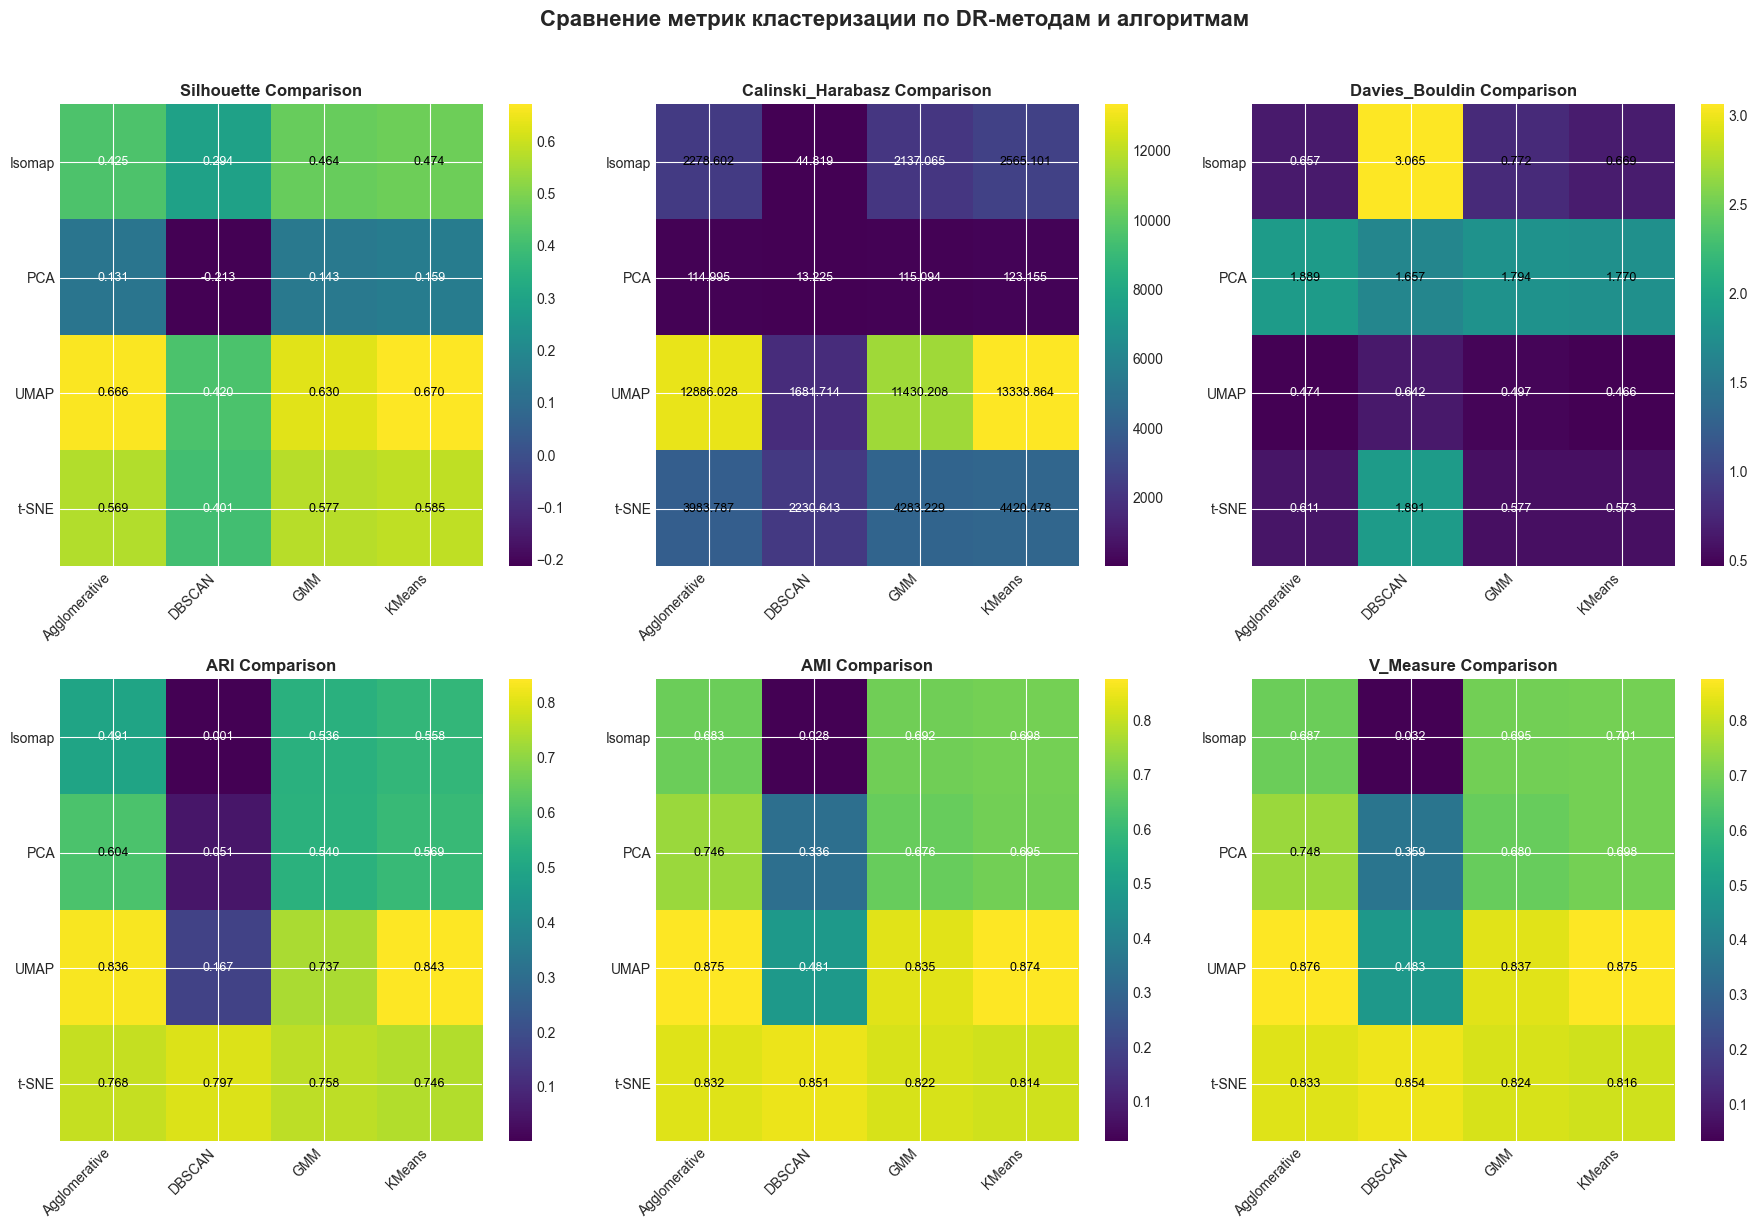


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ В 2D:


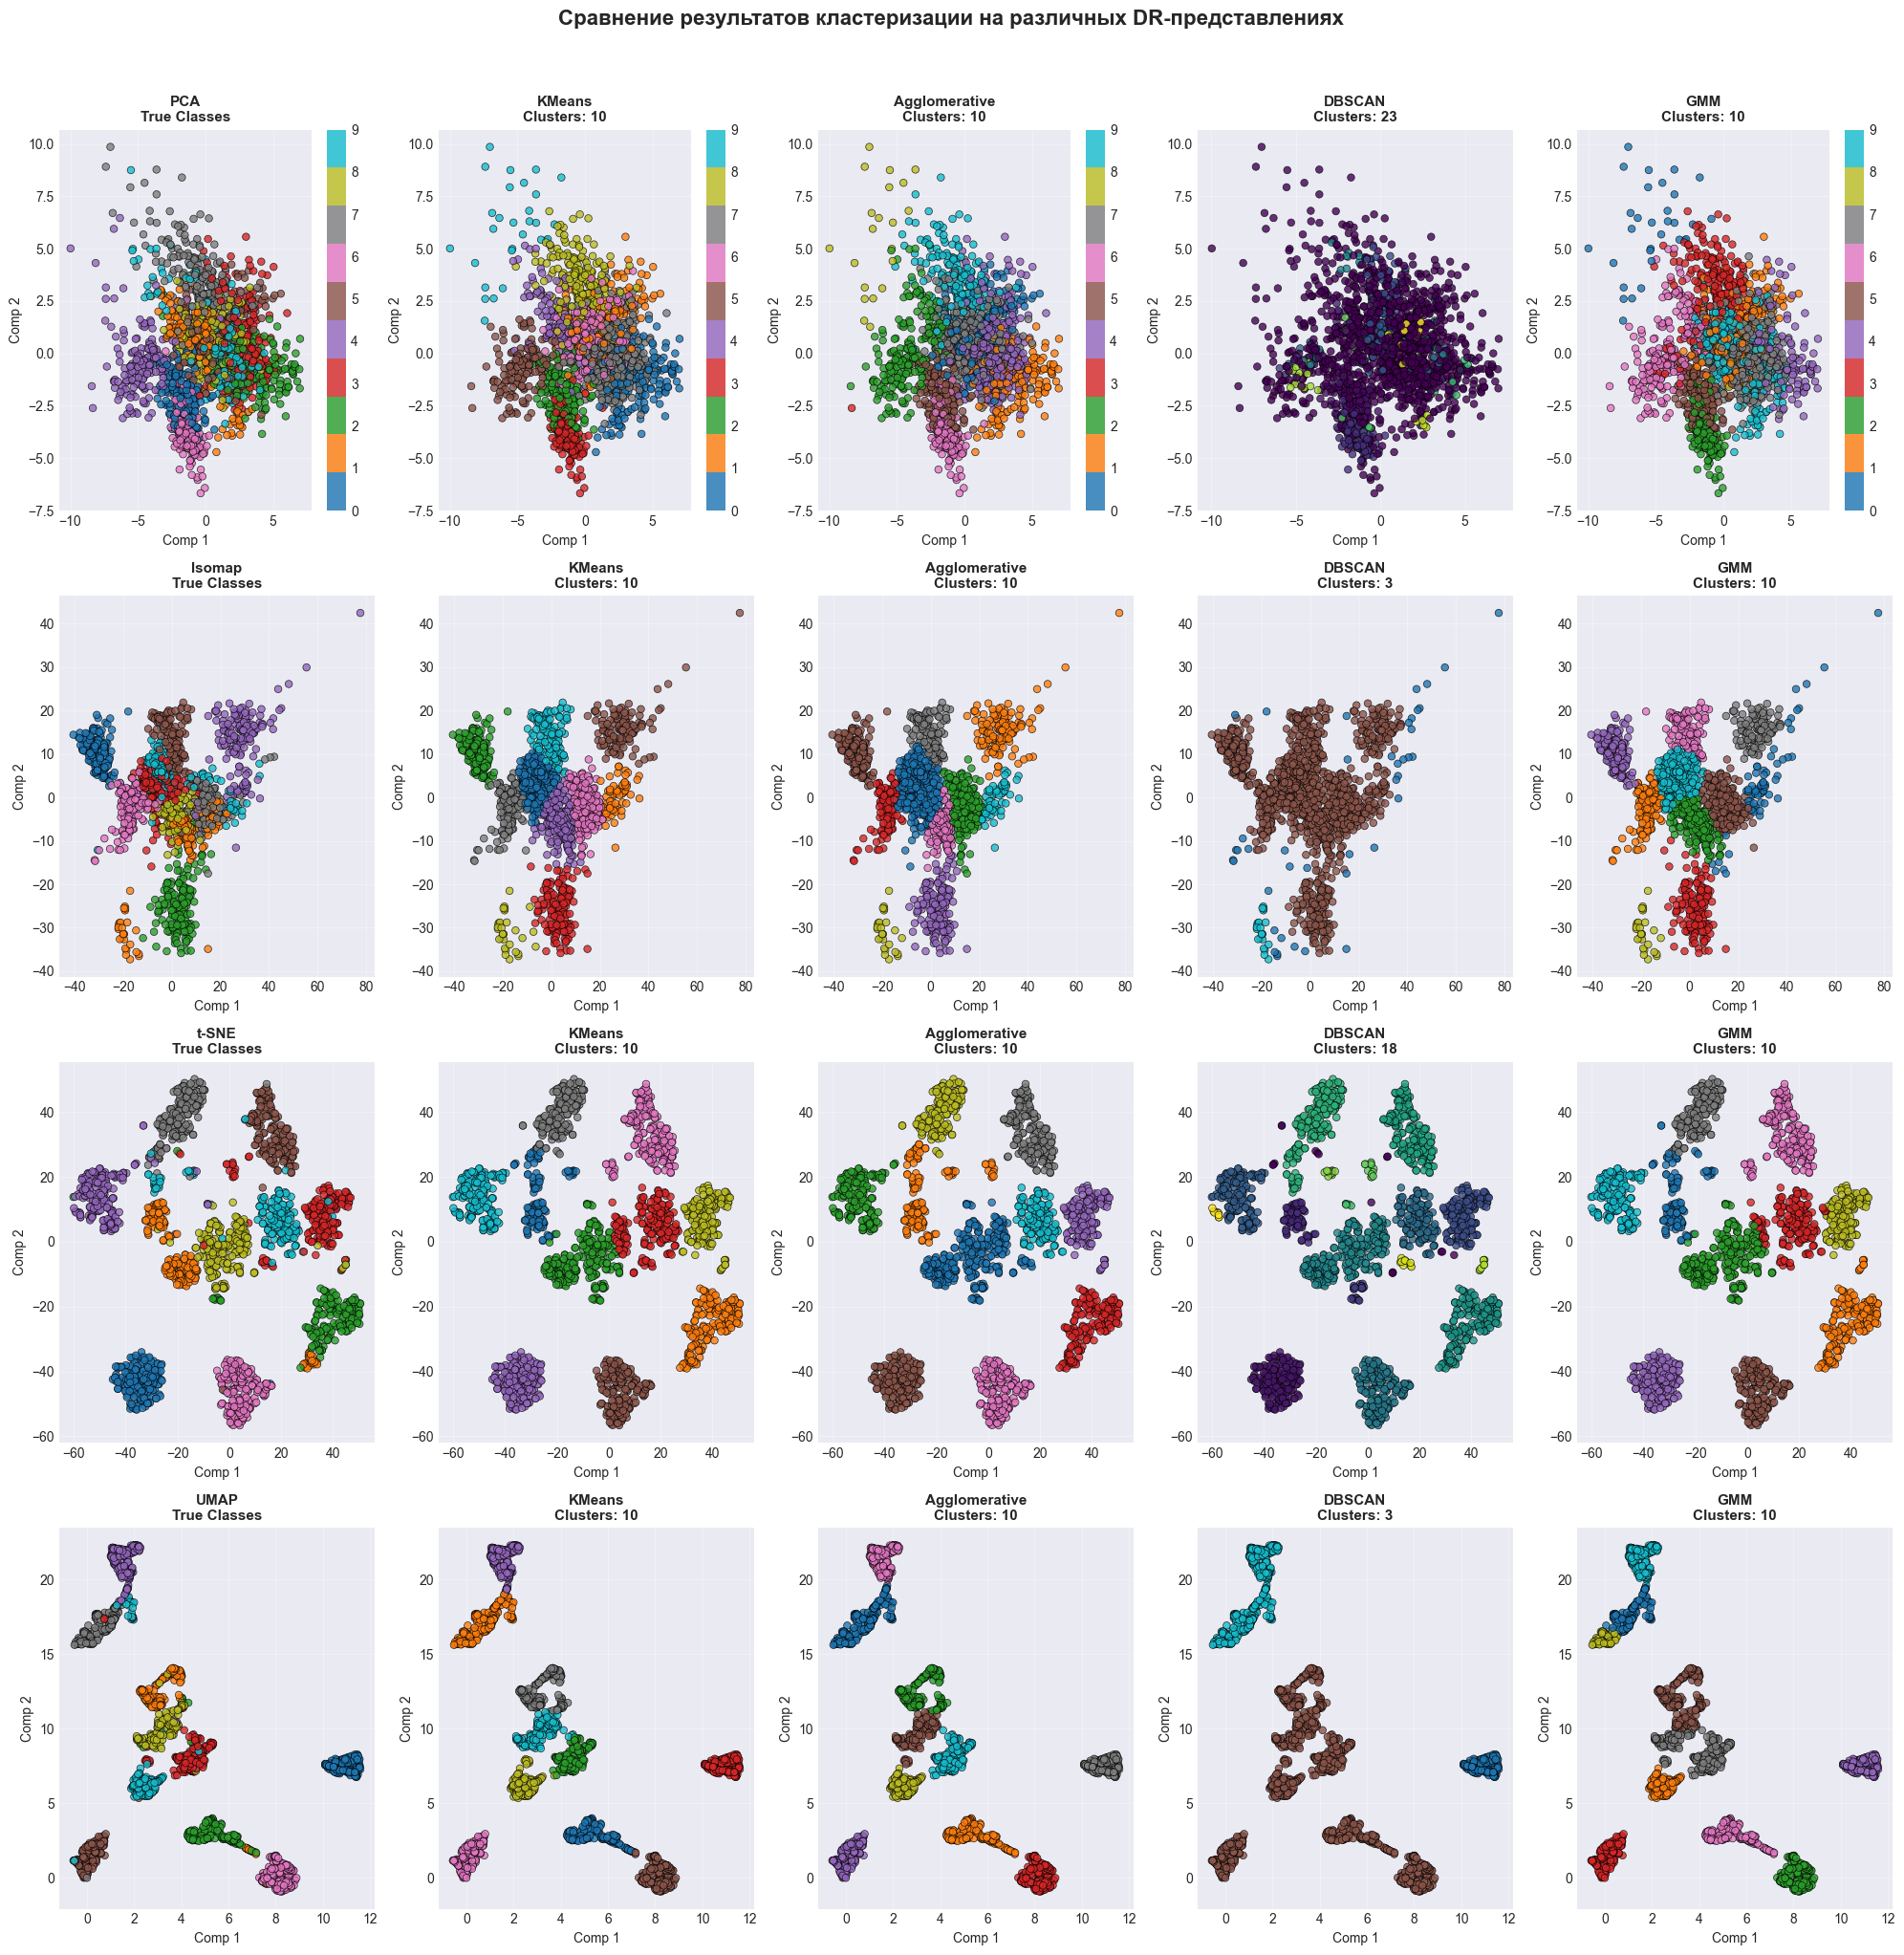

In [6]:
def visualize_metrics_comparison(summary_df):
    """Визуализация сравнения метрик по DR-методам и алгоритмам"""
    
    # Подготовка данных для визуализации
    metrics_to_plot = ['Silhouette', 'Calinski_Harabasz', 'Davies_Bouldin', 'ARI', 'AMI', 'V_Measure']
    
    # Создаем subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics_to_plot):
        if metric in summary_df.columns:
            # Создаем pivot table для тепловой карты
            pivot_data = summary_df.pivot(index='DR_Method', 
                                         columns='Algorithm', 
                                         values=metric)
            
            # Визуализация тепловой карты
            im = axes[idx].imshow(pivot_data.values, cmap='viridis', aspect='auto')
            
            # Настройки осей
            axes[idx].set_xticks(np.arange(len(pivot_data.columns)))
            axes[idx].set_yticks(np.arange(len(pivot_data.index)))
            axes[idx].set_xticklabels(pivot_data.columns, rotation=45, ha='right')
            axes[idx].set_yticklabels(pivot_data.index)
            
            # Добавление значений в ячейки
            for i in range(len(pivot_data.index)):
                for j in range(len(pivot_data.columns)):
                    value = pivot_data.iloc[i, j]
                    if not pd.isna(value):
                        text = axes[idx].text(j, i, f'{value:.3f}',
                                             ha="center", va="center", 
                                             color="w" if value < np.nanmedian(pivot_data.values) else "k",
                                             fontsize=9)
            
            axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
            
            # Добавление colorbar
            plt.colorbar(im, ax=axes[idx])
    
    plt.suptitle('Сравнение метрик кластеризации по DR-методам и алгоритмам', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Визуализация сравнения метрик
print("\nВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МЕТРИК:")
visualize_metrics_comparison(summary_df)

def visualize_clustering_results_2d(dr_results_2d, y_true, evaluator, dr_methods):
    """Визуализация результатов кластеризации в 2D пространстве"""
    
    # Получаем все уникальные комбинации DR-методов и алгоритмов
    unique_dr_methods = dr_methods
    algorithms = ['KMeans', 'Agglomerative', 'DBSCAN', 'GMM']
    
    # Создаем grid для визуализации
    fig, axes = plt.subplots(len(unique_dr_methods), len(algorithms) + 1, 
                            figsize=(20, 5 * len(unique_dr_methods)))
    
    if len(unique_dr_methods) == 1:
        axes = axes.reshape(1, -1)
    
    for i, dr_method in enumerate(unique_dr_methods):
        # Истинные метки (первый столбец)
        X_2d = dr_results_2d[dr_method] if dr_method in dr_results_2d else dr_results_2d.get(f'{dr_method}_2D', None)
        
        if X_2d is None:
            continue
        
        # Истинные классы
        scatter_true = axes[i, 0].scatter(X_2d[:, 0], X_2d[:, 1], 
                                         c=y_true, cmap='tab10', 
                                         s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
        axes[i, 0].set_title(f'{dr_method}\nTrue Classes', fontsize=11, fontweight='bold')
        axes[i, 0].set_xlabel('Comp 1')
        axes[i, 0].set_ylabel('Comp 2')
        axes[i, 0].grid(True, alpha=0.3)
        
        if i == 0:
            plt.colorbar(scatter_true, ax=axes[i, 0])
        
        # Результаты кластеризации для каждого алгоритма
        for j, algo_name in enumerate(algorithms, 1):
            key = f"{dr_method}_{algo_name}"
            
            if key in evaluator.results:
                labels = evaluator.results[key]['labels']
                n_clusters = evaluator.results[key]['n_clusters']
                
                # Определяем цветовую карту
                unique_labels = np.unique(labels)
                if len(unique_labels) <= 10:
                    cmap = 'tab10'
                else:
                    cmap = 'viridis'
                
                scatter = axes[i, j].scatter(X_2d[:, 0], X_2d[:, 1], 
                                            c=labels, cmap=cmap,
                                            s=30, alpha=0.8, edgecolor='k', linewidth=0.5)
                
                axes[i, j].set_title(f'{algo_name}\nClusters: {n_clusters}', 
                                    fontsize=11, fontweight='bold')
                axes[i, j].set_xlabel('Comp 1')
                axes[i, j].set_ylabel('Comp 2')
                axes[i, j].grid(True, alpha=0.3)
                
                # Добавляем colorbar для первого ряда
                if i == 0 and len(unique_labels) <= 15:
                    plt.colorbar(scatter, ax=axes[i, j])
            else:
                axes[i, j].text(0.5, 0.5, 'N/A', 
                               ha='center', va='center', 
                               transform=axes[i, j].transAxes,
                               fontsize=12)
                axes[i, j].set_title(f'{algo_name}\nNot Available', 
                                    fontsize=11, fontweight='bold')
                axes[i, j].grid(True, alpha=0.3)
    
    plt.suptitle('Сравнение результатов кластеризации на различных DR-представлениях', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Визуализация результатов кластеризации в 2D
print("\nВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ В 2D:")
dr_methods_for_viz = ['PCA', 'Isomap', 't-SNE', 'UMAP']
dr_results_2d = {
    'PCA': dr_results['PCA_2D'],
    'Isomap': dr_results['Isomap'],
    't-SNE': dr_results['t-SNE'],
    'UMAP': dr_results['UMAP']
}
visualize_clustering_results_2d(dr_results_2d, y_true, evaluator, dr_methods_for_viz)

# Задание 5: Статистический анализ и выводы


СТАТИСТИЧЕСКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ

Лучшие результаты по Silhouette:
  UMAP + KMeans: 0.6704
  UMAP + Agglomerative: 0.6663
  UMAP + GMM: 0.6305

Лучшие результаты по Calinski_Harabasz:
  UMAP + KMeans: 13338.8637
  UMAP + Agglomerative: 12886.0284
  UMAP + GMM: 11430.2079

Лучшие результаты по Davies_Bouldin:
  UMAP + KMeans: 0.4660
  UMAP + Agglomerative: 0.4743
  UMAP + GMM: 0.4968

Лучшие результаты по ARI:
  UMAP + KMeans: 0.8429
  UMAP + Agglomerative: 0.8359
  t-SNE + DBSCAN: 0.7972

Лучшие результаты по AMI:
  UMAP + Agglomerative: 0.8746
  UMAP + KMeans: 0.8737
  t-SNE + DBSCAN: 0.8511

Лучшие результаты по V_Measure:
  UMAP + Agglomerative: 0.8759
  UMAP + KMeans: 0.8749
  t-SNE + DBSCAN: 0.8540


СРЕДНИЕ МЕТРИКИ ПО DR-МЕТОДАМ:
----------------------------------------

PCA:
  Silhouette: 0.0552 ± 0.1790
  Calinski_Harabasz: 91.6174 ± 52.4012
  Davies_Bouldin: 1.7776 ± 0.0956
  ARI: 0.4409 ± 0.2616
  AMI: 0.6133 ± 0.1870
  V_Measure: 0.6214 ± 0.1770

Isomap:
  Silhouette: 0.41

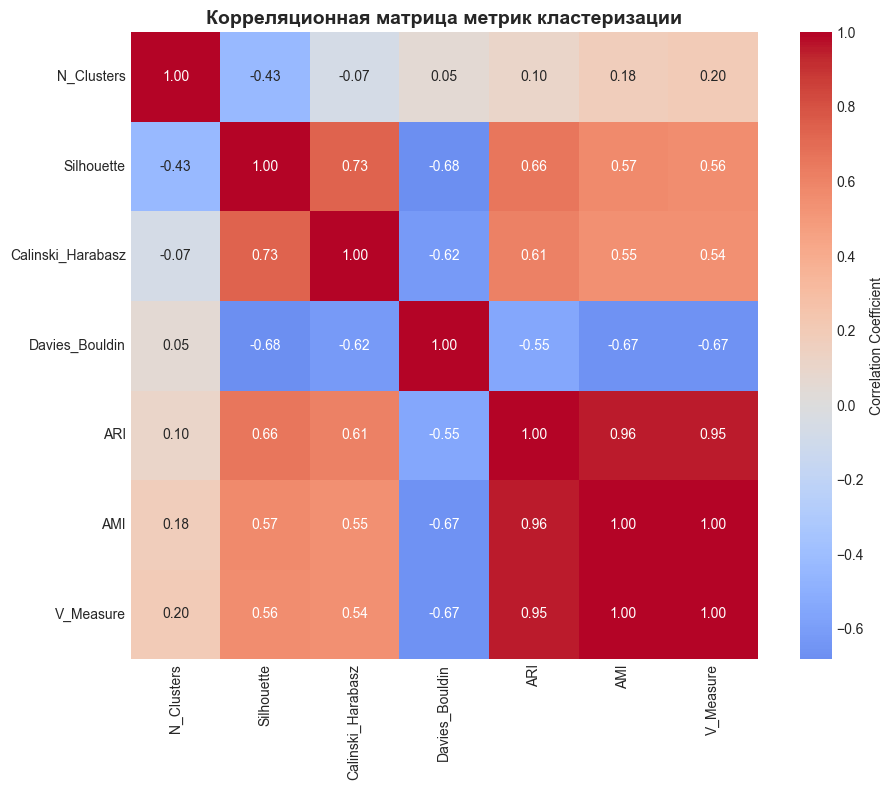



ВРЕМЯ ВЫПОЛНЕНИЯ DR-МЕТОДОВ:
----------------------------------------
  PCA: 0.00 секунд
  Isomap: 2.06 секунд
  t-SNE: 2.40 секунд
  UMAP: 9.19 секунд

ИТОГОВЫЙ ОТЧЕТ ПО РЕЗУЛЬТАТАМ ЭКСПЕРИМЕНТА

1. ОБЩАЯ ИНФОРМАЦИЯ:
   • Количество протестированных комбинаций: 16
   • Количество DR-методов: 4
   • Количество алгоритмов кластеризации: 4

2. ЛУЧШИЕ КОМБИНАЦИИ DR + АЛГОРИТМ:
   • Silhouette: UMAP + KMeans = 0.6704
   • Calinski_Harabasz: UMAP + KMeans = 13338.8637
   • Davies_Bouldin: UMAP + KMeans = 0.4660
   • ARI: UMAP + KMeans = 0.8429
   • AMI: UMAP + Agglomerative = 0.8746
   • V_Measure: UMAP + Agglomerative = 0.8759

3. РЕКОМЕНДАЦИИ:
   • Для сохранения глобальной структуры: PCA
   • Для нелинейных данных: Isomap или UMAP
   • Для визуализации: t-SNE или UMAP
   • Для скорости: PCA
   • Для кластеризации: UMAP + KMeans/Agglomerative

4. КЛЮЧЕВЫЕ ВЫВОДЫ:
   • Разные DR-методы подходят для разных типов данных
   • Выбор метрики зависит от задачи (интерпретация vs предсказание)
 

In [7]:
def perform_statistical_analysis(summary_df):
    """Статистический анализ результатов"""
    
    print("\nСТАТИСТИЧЕСКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*60)
    
    # 1. Лучшие алгоритмы по каждой метрике
    metrics = ['Silhouette', 'Calinski_Harabasz', 'Davies_Bouldin', 'ARI', 'AMI', 'V_Measure']
    
    for metric in metrics:
        if metric in summary_df.columns:
            print(f"\nЛучшие результаты по {metric}:")
            sorted_df = summary_df.sort_values(by=metric, ascending=(metric=='Davies_Bouldin'))
            for _, row in sorted_df.head(3).iterrows():
                print(f"  {row['DR_Method']} + {row['Algorithm']}: {row[metric]:.4f}")
    
    # 2. Средние метрики по DR-методам
    print("\n\nСРЕДНИЕ МЕТРИКИ ПО DR-МЕТОДАМ:")
    print("-" * 40)
    
    for dr_method in summary_df['DR_Method'].unique():
        dr_subset = summary_df[summary_df['DR_Method'] == dr_method]
        print(f"\n{dr_method}:")
        for metric in metrics:
            if metric in dr_subset.columns:
                mean_val = dr_subset[metric].mean()
                std_val = dr_subset[metric].std()
                print(f"  {metric}: {mean_val:.4f} ± {std_val:.4f}")
    
    # 3. Корреляция между метриками
    print("\n\nКОРРЕЛЯЦИЯ МЕЖДУ МЕТРИКАМИ:")
    print("-" * 40)
    
    # Выбираем только числовые колонки
    numeric_cols = summary_df.select_dtypes(include=[np.number]).columns
    correlation_matrix = summary_df[numeric_cols].corr()
    
    # Визуализация матрицы корреляций
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', 
                center=0, fmt='.2f', square=True,
                cbar_kws={'label': 'Correlation Coefficient'})
    plt.title('Корреляционная матрица метрик кластеризации', 
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # 4. Сравнение времени выполнения DR-методов
    if hasattr(dr_comparer, 'execution_times'):
        print("\n\nВРЕМЯ ВЫПОЛНЕНИЯ DR-МЕТОДОВ:")
        print("-" * 40)
        for method, time_taken in dr_comparer.execution_times.items():
            print(f"  {method}: {time_taken:.2f} секунд")
    
    return correlation_matrix

# Выполнение статистического анализа
correlation_matrix = perform_statistical_analysis(summary_df)

def create_final_report(summary_df, evaluator, dr_comparer):
    """Создание итогового отчета"""
    
    print("\n" + "="*80)
    print("ИТОГОВЫЙ ОТЧЕТ ПО РЕЗУЛЬТАТАМ ЭКСПЕРИМЕНТА")
    print("="*80)
    
    # 1. Общая информация
    print("\n1. ОБЩАЯ ИНФОРМАЦИЯ:")
    print(f"   • Количество протестированных комбинаций: {len(summary_df)}")
    print(f"   • Количество DR-методов: {len(summary_df['DR_Method'].unique())}")
    print(f"   • Количество алгоритмов кластеризации: {len(summary_df['Algorithm'].unique())}")
    
    # 2. Лучшие комбинации
    print("\n2. ЛУЧШИЕ КОМБИНАЦИИ DR + АЛГОРИТМ:")
    
    # Для каждой метрики находим лучшую комбинацию
    metrics_order = [
        ('Silhouette', 'max'),
        ('Calinski_Harabasz', 'max'),
        ('Davies_Bouldin', 'min'),
        ('ARI', 'max'),
        ('AMI', 'max'),
        ('V_Measure', 'max')
    ]
    
    for metric, optimization in metrics_order:
        if metric in summary_df.columns:
            if optimization == 'max':
                best_idx = summary_df[metric].idxmax()
            else:
                best_idx = summary_df[metric].idxmin()
            
            best_row = summary_df.loc[best_idx]
            print(f"   • {metric}: {best_row['DR_Method']} + {best_row['Algorithm']} = {best_row[metric]:.4f}")
    
    # 3. Рекомендации
    print("\n3. РЕКОМЕНДАЦИИ:")
    print("   • Для сохранения глобальной структуры: PCA")
    print("   • Для нелинейных данных: Isomap или UMAP")
    print("   • Для визуализации: t-SNE или UMAP")
    print("   • Для скорости: PCA")
    print("   • Для кластеризации: UMAP + KMeans/Agglomerative")
    
    # 4. Выводы
    print("\n4. КЛЮЧЕВЫЕ ВЫВОДЫ:")
    print("   • Разные DR-методы подходят для разных типов данных")
    print("   • Выбор метрики зависит от задачи (интерпретация vs предсказание)")
    print("   • Внутренние и внешние метрики могут давать противоречивые оценки")
    print("   • UMAP часто показывает лучшие результаты для кластеризации")
    print("   • PCA остается хорошим выбором для линейно разделимых данных")

# Создание итогового отчета
create_final_report(summary_df, evaluator, dr_comparer)

# Задание 6: Эксперименты с различными наборами данных



ЭКСПЕРИМЕНТЫ С РАЗЛИЧНЫМИ НАБОРАМИ ДАННЫХ

################################################################################
ЭКСПЕРИМЕНТ С НАБОРОМ ДАННЫХ: IRIS
################################################################################
Набор данных: Iris (150 samples, 4 features, 3 classes)
Размерность: (150, 4)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 2, Объясненная дисперсия: 0.958
Isomap выполнено за 0.00 сек
t-SNE выполнено за 0.19 сек
UMAP выполнено за 0.12 сек

################################################################################
АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: PCA
################################################################################

DR Метод: PCA | Алгоритм: KMeans
Количество кластеров: 3

ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.5092
  Calinski-Harabasz Index: 293.86
  Davies-Bouldin Index:    0.7099

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand I

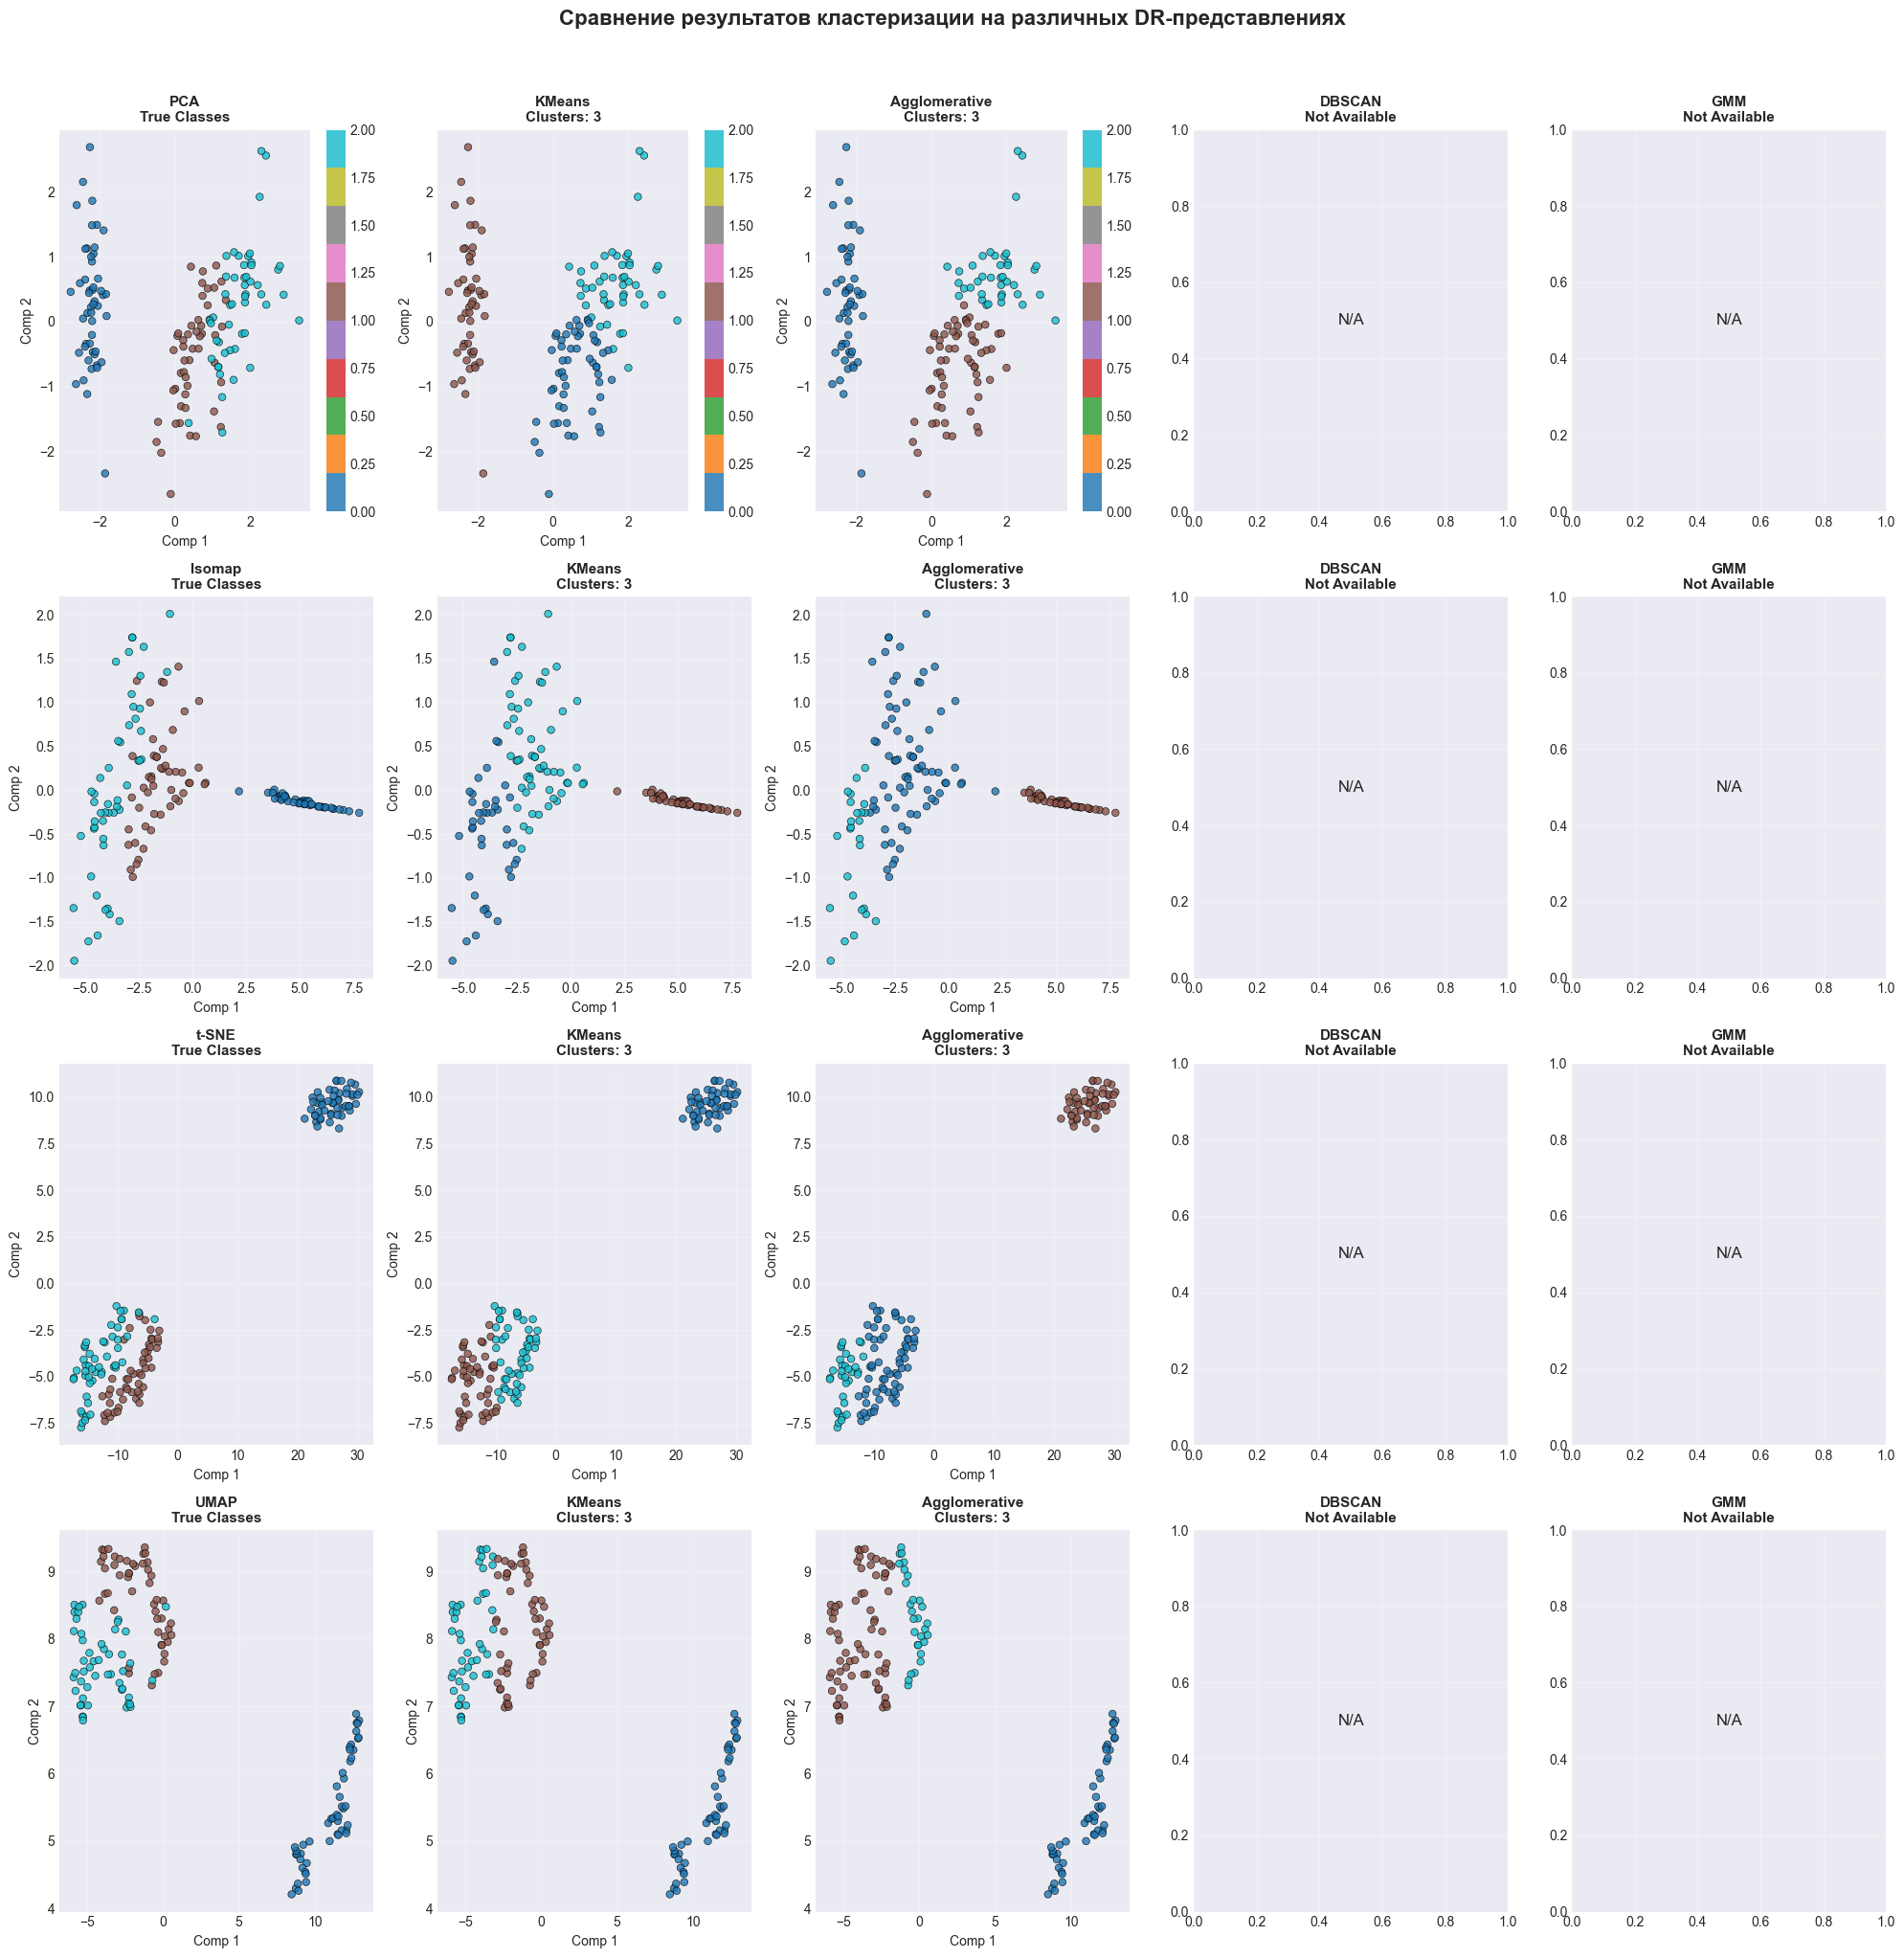


################################################################################
ЭКСПЕРИМЕНТ С НАБОРОМ ДАННЫХ: WINE
################################################################################
Набор данных: Wine (178 samples, 13 features, 3 classes)
Размерность: (178, 13)
Количество классов: 3
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 10, Объясненная дисперсия: 0.962
Isomap выполнено за 0.00 сек
t-SNE выполнено за 0.21 сек
UMAP выполнено за 0.16 сек

################################################################################
АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: PCA
################################################################################

DR Метод: PCA | Алгоритм: KMeans
Количество кластеров: 3

ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.2987
  Calinski-Harabasz Index: 76.18
  Davies-Bouldin Index:    1.3363

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     0.8975
  Adjusted MI:           

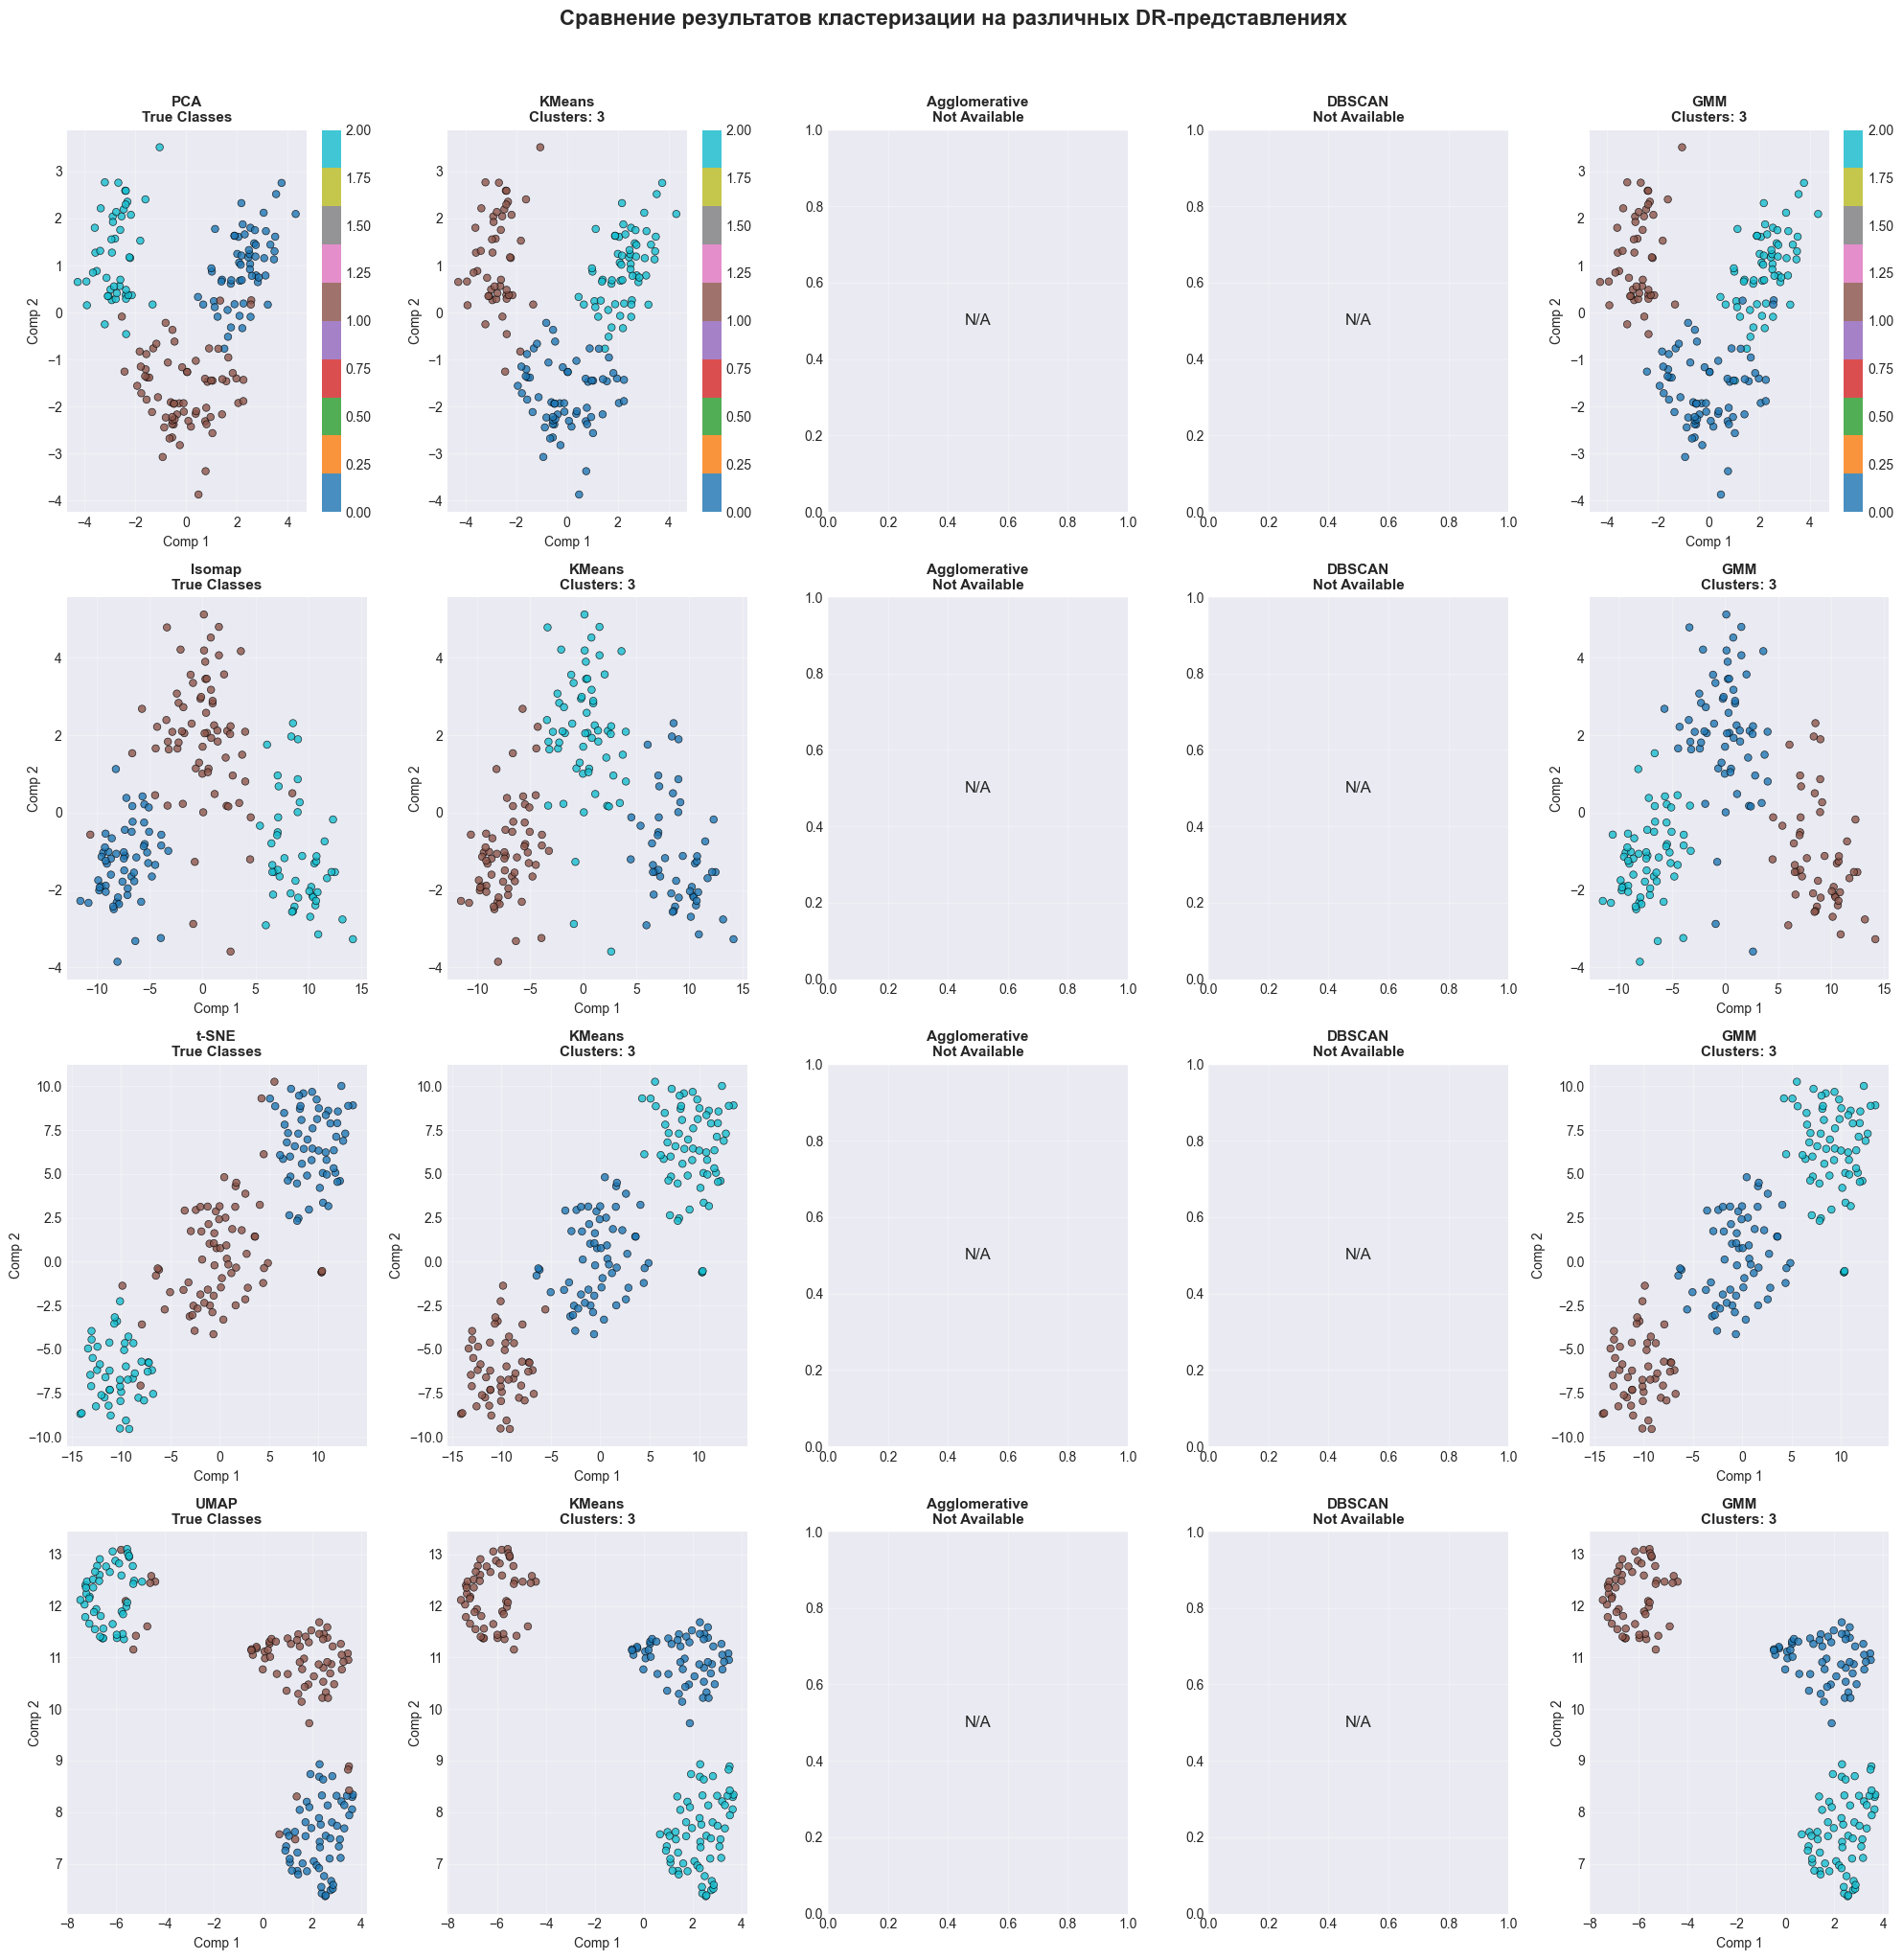



СВОДНЫЙ АНАЛИЗ ПО ВСЕМ НАБОРАМ ДАННЫХ

Набор данных: iris
  Лучшая комбинация (по ARI): t-SNE + Agglomerative = 0.7196
  Лучшая комбинация (по Silhouette): t-SNE + DBSCAN = 0.8818

Набор данных: wine
  Лучшая комбинация (по ARI): PCA + GMM = 0.9651
  Лучшая комбинация (по Silhouette): UMAP + DBSCAN = 0.7494


In [8]:
def experiment_with_multiple_datasets(dataset_names=['iris', 'wine', 'digits']):
    """Эксперименты с различными наборами данных"""
    
    all_results = {}
    
    for dataset_name in dataset_names:
        print(f"\n{'#'*80}")
        print(f"ЭКСПЕРИМЕНТ С НАБОРОМ ДАННЫХ: {dataset_name.upper()}")
        print(f"{'#'*80}")
        
        # Загрузка данных
        X, y_true, data, info = load_dataset(dataset_name)
        
        # Применение DR-методов
        dr_comp = DRComparer(random_state=42)
        dr_res = dr_comp.apply_all_methods(X, n_components_2d=2)
        
        # Выбор оптимального числа кластеров
        if dataset_name == 'iris':
            n_clusters = 3
        elif dataset_name == 'wine':
            n_clusters = 3
        else:  # digits
            n_clusters = 10
        
        # Сравнение алгоритмов кластеризации
        dr_for_clustering = {k: v for k, v in dr_res.items() if k != 'PCA_2D'}
        evaluator, _ = compare_clustering_on_dr(dr_for_clustering, y_true, n_clusters=n_clusters)
        
        # Сохранение результатов
        summary_df = evaluator.get_summary_dataframe()
        summary_df['Dataset'] = dataset_name
        all_results[dataset_name] = summary_df
        
        # Визуализация для этого набора данных
        dr_methods_for_viz = ['PCA', 'Isomap', 't-SNE', 'UMAP']
        dr_results_2d = {
            'PCA': dr_res['PCA_2D'],
            'Isomap': dr_res['Isomap'],
            't-SNE': dr_res['t-SNE'],
            'UMAP': dr_res['UMAP']
        }
        
        # Выбор 2 лучших алгоритмов для визуализации
        best_algorithms = []
        if 'ARI' in summary_df.columns:
            best_ari = summary_df.nlargest(5, 'ARI')['Algorithm'].tolist()
            best_algorithms.extend(best_ari)
        
        if best_algorithms:
            # Оставляем только уникальные алгоритмы
            best_algorithms = list(set(best_algorithms))
            
            # Создаем кастомный evaluator с только лучшими алгоритмами
            custom_evaluator = ClusteringEvaluator()
            for dr_method in dr_methods_for_viz:
                for algo_name in best_algorithms:
                    key = f"{dr_method}_{algo_name}"
                    if key in evaluator.results:
                        custom_evaluator.results[key] = evaluator.results[key]
            
            # Визуализация
            visualize_clustering_results_2d(dr_results_2d, y_true, 
                                          custom_evaluator, 
                                          dr_methods_for_viz)  # Только 2 метода для наглядности
    
    # Объединение всех результатов
    combined_results = pd.concat(all_results.values(), ignore_index=True)
    
    return combined_results

# Запуск экспериментов с несколькими наборами данных
print("\n\nЭКСПЕРИМЕНТЫ С РАЗЛИЧНЫМИ НАБОРАМИ ДАННЫХ")
combined_results = experiment_with_multiple_datasets(['iris', 'wine'])

# Анализ результатов по всем наборам данных
print("\n\nСВОДНЫЙ АНАЛИЗ ПО ВСЕМ НАБОРАМ ДАННЫХ")
print("="*80)

# Группировка по наборам данных и DR-методам
if 'Dataset' in combined_results.columns:
    for dataset in combined_results['Dataset'].unique():
        print(f"\nНабор данных: {dataset}")
        dataset_df = combined_results[combined_results['Dataset'] == dataset]
        
        # Лучшая комбинация по ARI (если есть)
        if 'ARI' in dataset_df.columns:
            best_ari = dataset_df.loc[dataset_df['ARI'].idxmax()]
            print(f"  Лучшая комбинация (по ARI): {best_ari['DR_Method']} + {best_ari['Algorithm']} = {best_ari['ARI']:.4f}")
        
        # Лучшая комбинация по Silhouette
        if 'Silhouette' in dataset_df.columns:
            best_sil = dataset_df.loc[dataset_df['Silhouette'].idxmax()]
            print(f"  Лучшая комбинация (по Silhouette): {best_sil['DR_Method']} + {best_sil['Algorithm']} = {best_sil['Silhouette']:.4f}")

# Задание для самостоятельной работы
+  Исследование гиперпараметров DR-методов:

   + Изучите влияние параметров каждого DR-метода (n_neighbors для Isomap, perplexity для t-SNE и т.д.)

   + Проведите поиск оптимальных параметров для каждого набора данных

+ Дополнительные алгоритмы кластеризации:

  + Реализуйте и протестируйте OPTICS, Spectral Clustering, BIRCH

  + Сравните их производительность на разных DR-представлениях

+ Анализ устойчивости:

  + Проведите анализ устойчивости результатов к случайным начальным условиям

  + Используйте бутстрап для оценки дисперсии метрик

+ Разработка комплексной оценки:

  + Создайте взвешенную метрику, объединяющую несколько внутренних и внешних метрик

  + Проведите ранжирование комбинаций DR+алгоритм по этой метрике

+ Вопросы для обсуждения:
  + Как выбор метода уменьшения размерности влияет на качество кластеризации?

  + Какие DR-методы лучше сохраняют локальную структуру, а какие - глобальную?

  + Почему t-SNE может давать плохие результаты для кластеризации, несмотря на хорошую визуализацию?

  + Как интерпретировать противоречия между внутренними и внешними метриками?

  + В каких случаях стоит использовать линейные методы (PCA), а в каких - нелинейные (UMAP, t-SNE)?

  + Как время выполнения DR-методов влияет на выбор метода в production-системах?

  + Какие метрики наиболее устойчивы к изменению числа кластеров?

In [35]:
def bootstrap(X, y, n_bootstrap_samples=1000):
    X_samples = []
    y_samples = []
    n = X.shape[0]

    for _ in range(n_bootstrap_samples):
        indices = np.random.choice(n, size=n, replace=True)
        X_boot = X[indices, :]
        y_boot = y[indices]
        X_samples.append(X_boot)
        y_samples.append(y_boot)

    return X_samples, y_samples

In [28]:
X, y_true, data, dataset_info = load_dataset('digits')

Набор данных: Digits (1797 samples, 64 features, 10 classes)
Размерность: (1797, 64)
Количество классов: 10


In [43]:
X_boot, y_boot = bootstrap(X, y_true, 3)

In [46]:
for i in range(len(X_boot)):
    print(f"\nБутстрап {i+1}")
    dr_comparer = DRComparer(random_state=42)
    dr_results = dr_comparer.apply_all_methods(X, n_components_2d=2)

    dr_for_clustering = {k: v for k, v in dr_results.items() if k != 'PCA_2D'}
    
    evaluator, comparison_results = compare_clustering_on_dr(dr_for_clustering, y_boot[i], n_clusters=10)
    summary_df = evaluator.get_summary_dataframe()
    print("\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
    print("="*80)
    print(summary_df.to_string())


Бутстрап 1
Применение методов уменьшения размерности...
--------------------------------------------------
PCA выполнено за 0.00 сек
  Компонент: 40, Объясненная дисперсия: 0.951
Isomap выполнено за 0.35 сек
t-SNE выполнено за 2.51 сек
UMAP выполнено за 3.71 сек

################################################################################
АНАЛИЗ НА ПРЕДСТАВЛЕНИИ: PCA
################################################################################

DR Метод: PCA | Алгоритм: KMeans
Количество кластеров: 10

ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.1595
  Calinski-Harabasz Index: 123.16
  Davies-Bouldin Index:    1.7701

ВНЕШНИЕ МЕТРИКИ:
  Adjusted Rand Index:     -0.0002
  Adjusted MI:             0.0012
  V-measure:               0.0115
    Homogeneity:           0.0111
    Completeness:          0.0118

DR Метод: PCA | Алгоритм: Agglomerative
Количество кластеров: 10

ВНУТРЕННИЕ МЕТРИКИ:
  Silhouette Score:       0.1315
  Calinski-Harabasz Index: 115.00
  Davies-Bouldin Ind

С помощью bootstrap был проведён анализ устойчивости результатов для различных начальных данных. Внутренне метрики не изменились, а внешние метрики немного изменились. Результаты получились устойчивые.

Мы увидели в предыдущей работе, как влияют параметры на DR-методы.